In [1]:
# Add pyWRspice location to system path, if you haven't run setup.py
import sys
import re
import pandas as pd
sys.path.append("pyWRspice/")
import numpy as np
import logging, importlib
from pyWRspice.pyWRspice import script, simulation, remote

import matplotlib.pyplot as plt
%matplotlib inline
logging.basicConfig(level=logging.WARNING)

from helper import *
engine = simulation.WRWrapper(command = "/mnt/c/Users/pstark/xictools/wrspice/bin/wrspice") # Typical for Unix

In [47]:
dc_bias = """* DC Bias circuit
.model jj1 jj(level={level}, icrit={icrit_mag})
* i1 0 1 ac sin({i1_phase} {i1_mag} {i1_freq})
* idc 0 1 pulse(0 {idc_mag} 4e-07 0 0 1e-07)
idc 0 1 {idc_mag}
* idc2 2 0 1e-10
l0 1 0 {l0_mag}
k1 l0 l1 {k1_mag}
l1 0 2 {l1_mag}
l2 3 0 {l2_mag}
b1 2 3 101 jj1 ics={ics_mag} phi={phi1_mag}
.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} i(l2) v(101)
 .endc
"""

sw = simulation.WRWrapper(dc_bias, command = "/mnt/c/Users/pstark/xictools/wrspice/bin/wrspice")

In [13]:
params = {'level':1, 'icrit_mag': 1.0e-6, 'i1_phase': 0, 'i1_mag': 1e-7, 'i1_freq': 30e6, 'idc_mag': 1e-5,
          'l0_mag': 3e-10, 'k1_mag': 1, 'l1_mag': 3e-10, 'ics_mag': 1.1e-6, 'phi1_mag': 0,
          'l2_mag': 3e-10, 'tran_step': 1e-12, 'tran_stop': 6e-7, 'tran_start': 3e-7, 'maxdata': 1024000, 'output_file': None}

ibc_ratio = 0
params['idc_mag'] = params['ics_mag'] * ibc_ratio

print(dc_bias.format(**params))

* DC Bias circuit
.model jj1 jj(level=1, icrit=1e-06)
* i1 0 1 ac sin(0 1e-07 30000000.0)
* idc 0 1 pulse(0 0.0 4e-07 0 0 1e-07)
idc 0 1 0.0
* idc2 2 0 1e-10
l0 1 0 3e-10
k1 l0 l1 1
l1 0 2 3e-10
l2 3 0 0
b1 2 3 101 jj1 ics=1.1e-06 phi=0
.tran 1e-12 6e-07 3e-07 uic 
.control
set maxdata=1024000
run
set filetype=binary
write None i(l1) i(l2)
 .endc



#### Demonstration of behavior with low bias current: we see that the current across the junction aligns with expectations

In [10]:
%%time
# Run the simulation engine
dat = engine.run(dc_bias, save_file=False, **params)
# Extract the data
dat = dat.to_array()
ts = dat[0]
il2 = dat[1]
phi = dat[2]

CPU times: user 0 ns, sys: 31.2 ms, total: 31.2 ms
Wall time: 21.6 s


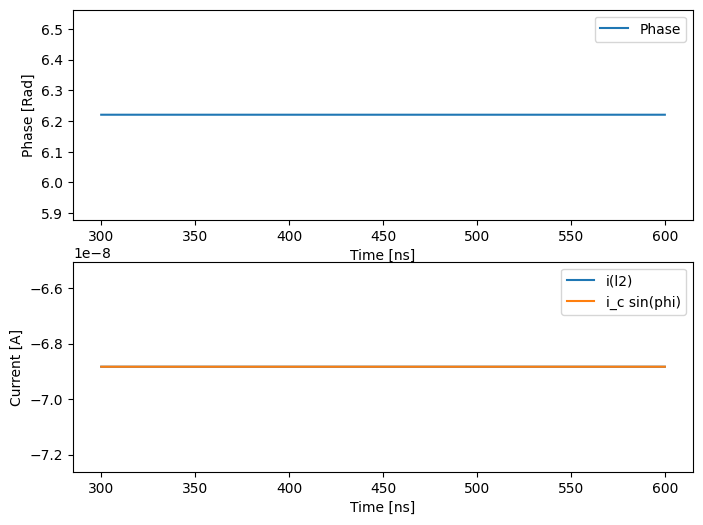

In [11]:
# Plot the data
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].plot(ts*1e9, np.round(phi%(2*np.pi), 10), label="Phase")
ax[0].set_xlabel("Time [ns]")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

ax[1].plot(ts*1e9, np.round(np.array(il2), 16), label="i(l2)")
ax[1].plot(ts*1e9, np.round(params['ics_mag'] * np.sin(phi), 16), label="i_c sin(phi)")
ax[1].set_xlabel("Time [ns]")
ax[1].set_ylabel("Current [A]")
ax[1].legend()

### Now we will do some parameter sweeps to demonstrate subcritical current behavior 

In [26]:
%%time
# Recycle params above
params["idc_mag"] = params['ics_mag'] * np.logspace(-4, -1, 50)
params3, dat3 = engine.run_parallel(dc_bias, save_file=False, **params)

# Extract data
idcs = params3["idc_mag"]
il2s = []
phis = []
for dat in dat3:
    il2s.append(dat.to_array()[1])
    phis.append(dat.to_array()[2])
ts = dat.to_array()[0]
il2s = np.array(il2s)
phis = np.array(phis)

CPU times: user 250 ms, sys: 438 ms, total: 688 ms
Wall time: 1min 43s


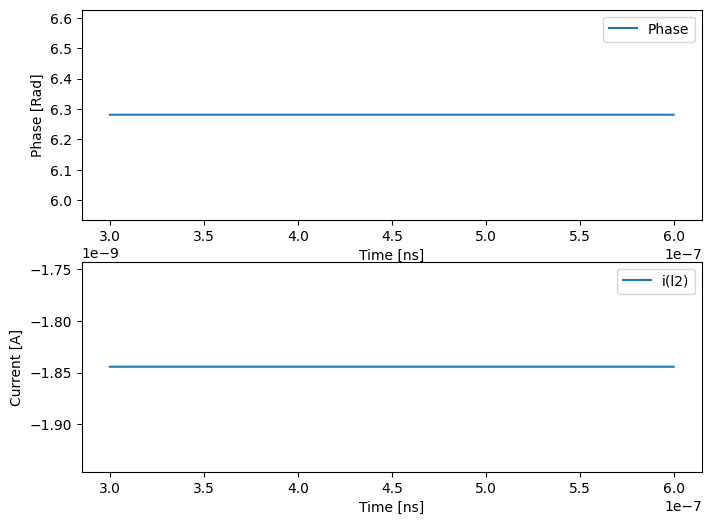

In [27]:
# for i in range(20, 21):
    # Plot the data
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].plot(ts, np.round(phis[20, :]%(2*np.pi), 10), label="Phase")
ax[0].set_xlabel("Time [ns]")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

ax[1].plot(ts, np.array(il2s[20, :]), label="i(l2)")
# #ax[1].plot(ts*1e9, params['ics_mag'] * np.sin(phi), label="i_c sin(phi)")
ax[1].set_xlabel("Time [ns]")
ax[1].set_ylabel("Current [A]")
ax[1].legend()

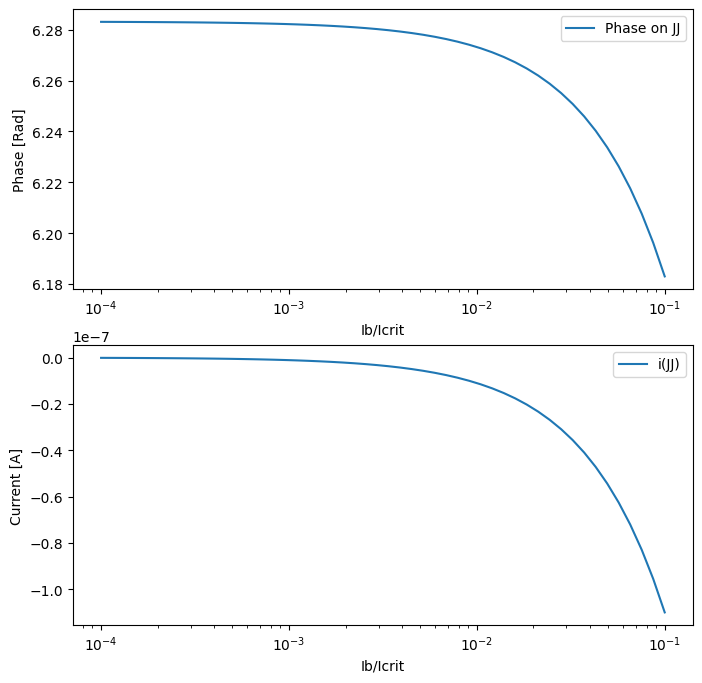

In [31]:
# Plot the data
fig, ax = plt.subplots(2, 1, figsize=(8,8))
ax[0].plot(np.logspace(-4, -1, 50), np.array(phis[:, -2]%(2*np.pi)), label="Phase on JJ")
ax[0].set_xlabel("Ib/Icrit")
ax[0].set_ylabel("Phase [Rad]")
#ax[0].set_xscale('log')
ax[0].legend()

ax[1].plot(np.logspace(-4, -1, 50), np.round(np.array(il2s[:, -2]), 20), label="i(JJ)")
#ax[1].plot(params["idc_mag"], params['ics_mag'] * np.sin(phis[:, -5]), label="i_c sin(phi)")
ax[1].set_xlabel("Ib/Icrit")
ax[1].set_ylabel("Current [A]")
#ax[1].set_xscale('log')
ax[1].legend()

### Now lets look at the regime where the bias current is much larger than the critical current

In [20]:
%%time
# Recycle params above
params["idc_mag"] = params['ics_mag'] * np.linspace(0, 10, 100)
params3, dat3 = engine.run_parallel(dc_bias, save_file=False, **params)

# Extract data
idcs = params3["idc_mag"]
il2s = []
phis = []
for dat in dat3:
    il2s.append(dat.to_array()[1])
    phis.append(dat.to_array()[2])
ts = dat.to_array()[0]
il2s = np.array(il2s)
phis = np.array(phis)

CPU times: user 547 ms, sys: 828 ms, total: 1.38 s
Wall time: 3min 3s


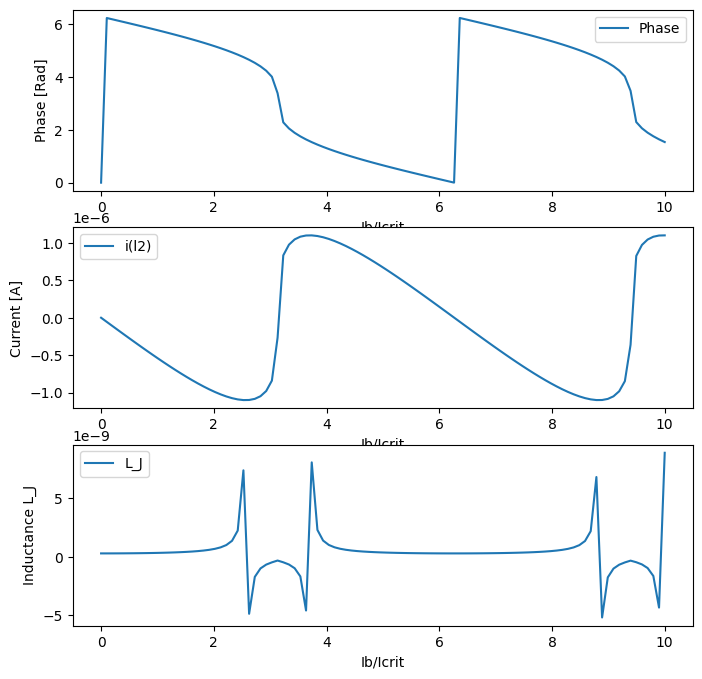

In [24]:
# Plot the data
fig, ax = plt.subplots(3, 1, figsize=(8,8))
ax[0].plot(np.linspace(0, 10, 100),  np.round(np.array(phis[:, -5]%(2*np.pi)), 12), label="Phase")
ax[0].set_xlabel("Ib/Icrit")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

ax[1].plot(np.linspace(0, 10, 100), np.round(np.array(il2s[:, -5]), 16), label="i(l2)")
#ax[1].plot(np.logspace(3, 5, 10), params['ics_mag'] * np.sin(phis[:, -5]), label="i_c sin(phi)")
ax[1].set_xlabel("Ib/Icrit")
ax[1].set_ylabel("Current [A]")
ax[1].legend()

ax[2].plot(np.linspace(0, 10, 100), 3e-10/np.cos(phis[:, -5]), label="L_J")
ax[2].set_xlabel("Ib/Icrit")
ax[2].set_ylabel("Inductance L_J")
ax[2].legend()

### We are seeing expected inductance behavior from circuit. Now let's see the behavior in a different inductance regime.

In [25]:
params['l0_mag'] = 3e-12
params['l1_mag'] = params['l0_mag'] * 1

In [30]:
%%time
# Recycle params above
params["idc_mag"] = params['ics_mag'] * np.linspace(0, 1000, 100)
params3, dat3 = engine.run_parallel(dc_bias, save_file=False, **params)

# Extract data
idcs = params3["idc_mag"]
il2s = []
phis = []
for dat in dat3:
    il2s.append(dat.to_array()[1])
    phis.append(dat.to_array()[2])
ts = dat.to_array()[0]
il2s = np.array(il2s)
phis = np.array(phis)

CPU times: user 609 ms, sys: 750 ms, total: 1.36 s
Wall time: 3min 4s


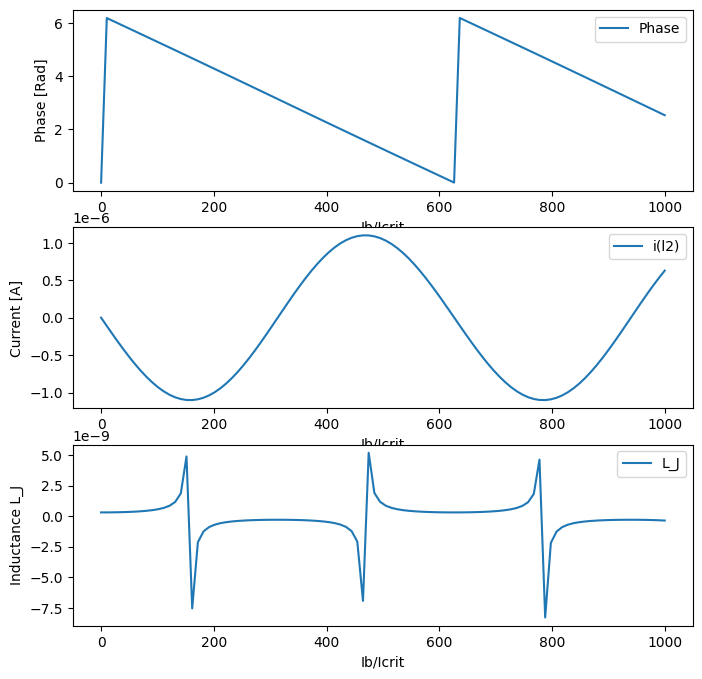

In [32]:
# Plot the data
fig, ax = plt.subplots(3, 1, figsize=(8,8))
ax[0].plot(np.linspace(0, 1000, 100),  np.round(np.array(phis[:, -5]%(2*np.pi)), 12), label="Phase")
ax[0].set_xlabel("Ib/Icrit")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

ax[1].plot(np.linspace(0, 1000, 100), np.round(np.array(il2s[:, -5]), 16), label="i(l2)")
#ax[1].plot(np.logspace(3, 5, 10), params['ics_mag'] * np.sin(phis[:, -5]), label="i_c sin(phi)")
ax[1].set_xlabel("Ib/Icrit")
ax[1].set_ylabel("Current [A]")
ax[1].legend()

ax[2].plot(np.linspace(0, 1000, 100), 3e-10/np.cos(phis[:, -5]), label="L_J")
ax[2].set_xlabel("Ib/Icrit")
ax[2].set_ylabel("Inductance L_J")
ax[2].legend()

In [63]:
from scipy import interpolate

f = interpolate.interp1d(np.round(np.array(phis[:, -5]%(2*np.pi)))[:40], np.linspace(0, 1000, 100)[:40])
f(3.1415)

array(346.58080808)

### This is really cool! We realize that there is a point of stability where the inductance on the Josephson junction is negative. Let's zoom in...

In [75]:
%%time
# Recycle params above
params["idc_mag"] = params['ics_mag'] * 346.58
params["l2_mag"] = 0

dat = engine.run(dc_bias, save_file=False, **params)
# Extract the data
dat = dat.to_array()
ts = dat[0]
il2 = dat[1]
phi = dat[2]

CPU times: user 0 ns, sys: 31.2 ms, total: 31.2 ms
Wall time: 21.6 s


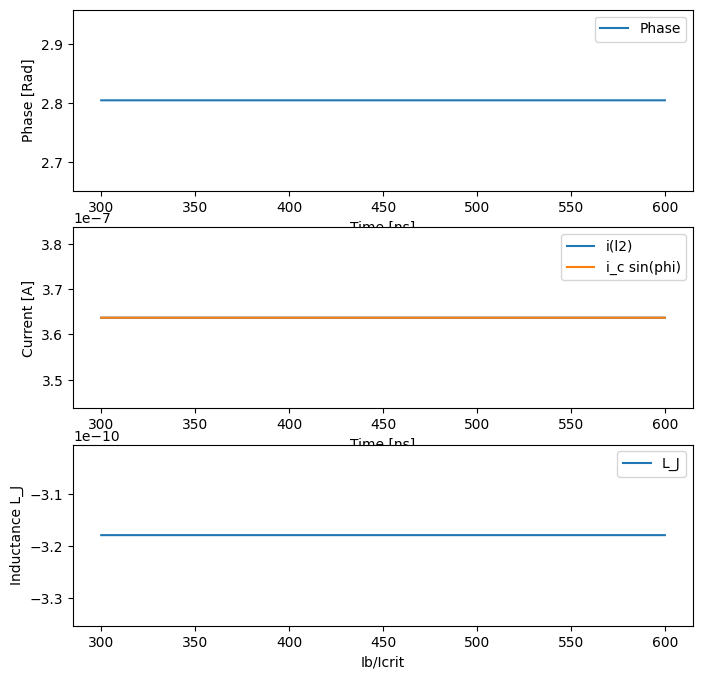

In [78]:
# Plot the data
fig, ax = plt.subplots(3, 1, figsize=(8,8))
ax[0].plot(ts*1e9, np.round(phi%(2*np.pi), 10), label="Phase")
ax[0].set_xlabel("Time [ns]")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

ax[1].plot(ts*1e9, np.round(np.array(il2), 10), label="i(l2)")
ax[1].plot(ts*1e9, np.round(params['ics_mag'] * np.sin(phi), 10), label="i_c sin(phi)")
ax[1].set_xlabel("Time [ns]")
ax[1].set_ylabel("Current [A]")
ax[1].legend()

ax[2].plot(ts*1e9, 3e-10/np.cos(np.round(phi, 10)), label="L_J")
ax[2].set_xlabel("Ib/Icrit")
ax[2].set_ylabel("Inductance L_J")
ax[2].legend()

In [79]:
print(3e-10/np.cos(np.round(phi, 12)))

[-3.17873505e-10 -3.17873505e-10 -3.17873505e-10 ... -3.17873505e-10
 -3.17873505e-10 -3.17873505e-10]


### This seems to be a stable point...? Let's try re-adding in the inductance on L2

In [84]:
%%time
# Recycle params above
params["l2_mag"] = 3e-10

dat = engine.run(dc_bias, save_file=False, **params)
# Extract the data
dat = dat.to_array()
ts = dat[0]
il2 = dat[1]
phi = dat[2]

CPU times: user 0 ns, sys: 31.2 ms, total: 31.2 ms
Wall time: 21.5 s


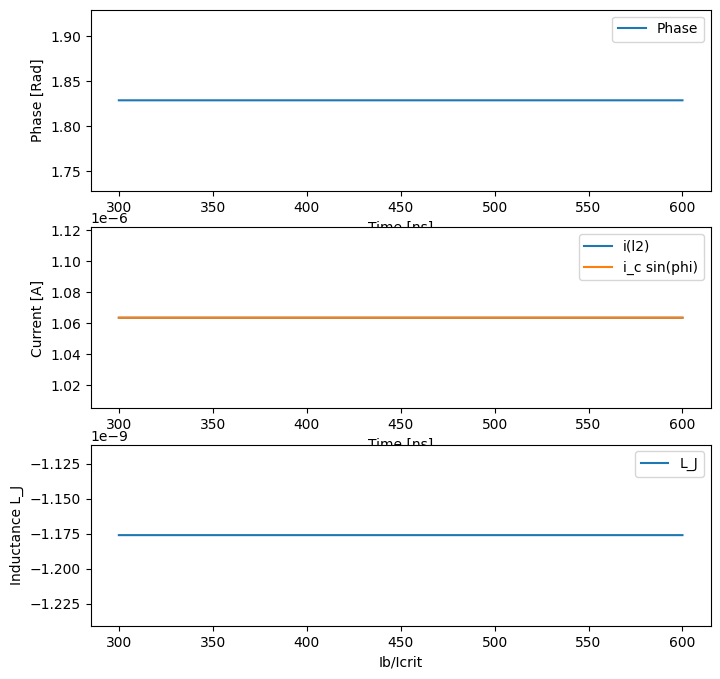

In [86]:
# Plot the data
fig, ax = plt.subplots(3, 1, figsize=(8,8))
ax[0].plot(ts*1e9, np.round(phi%(2*np.pi), 10), label="Phase")
ax[0].set_xlabel("Time [ns]")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

ax[1].plot(ts*1e9, np.round(np.array(il2), 10), label="i(l2)")
ax[1].plot(ts*1e9, np.round(params['ics_mag'] * np.sin(phi), 10), label="i_c sin(phi)")
ax[1].set_xlabel("Time [ns]")
ax[1].set_ylabel("Current [A]")
ax[1].legend()

ax[2].plot(ts*1e9, 3e-10/np.cos(np.round(phi, 10)), label="L_J")
ax[2].set_xlabel("Ib/Icrit")
ax[2].set_ylabel("Inductance L_J")
ax[2].legend()

### We realize that the presence of a non-zero L2 inductor shifts the phase across the Josephson Junction. Let's now fix the value of L2 and redo our sweep over the bias values. 

In [ ]:
%%time
# Recycle params above
params["idc_mag"] = params['ics_mag'] * np.linspace(100, 800, 100)
params3, dat3 = engine.run_parallel(dc_bias, save_file=False, **params)

# Extract data
idcs = params3["idc_mag"]
il2s = []
phis = []
for dat in dat3:
    il2s.append(dat.to_array()[1])
    phis.append(dat.to_array()[2])
ts = dat.to_array()[0]
il2s = np.array(il2s)
phis = np.array(phis)

In [ ]:
# Plot the data
fig, ax = plt.subplots(3, 1, figsize=(8,8))
ax[0].plot(np.linspace(100, 800, 100),  np.round(np.array(phis[:, -5]%(2*np.pi)), 12), label="Phase")
ax[0].set_xlabel("Ib/Icrit")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

ax[1].plot(np.linspace(100, 800, 100), np.round(np.array(il2s[:, -5]), 16), label="i(l2)")
#ax[1].plot(np.logspace(3, 5, 10), params['ics_mag'] * np.sin(phis[:, -5]), label="i_c sin(phi)")
ax[1].set_xlabel("Ib/Icrit")
ax[1].set_ylabel("Current [A]")
ax[1].legend()

ax[2].plot(np.linspace(100, 800, 100), 3e-10/np.cos(np.round(np.array(il2s[:, -5]), 16)), label="L_J")
ax[2].set_xlabel("Ib/Icrit")
ax[2].set_ylabel("Inductance L_J")
ax[2].legend()

In [ ]:
### Find bias current at which pi -- fix L2 change bias

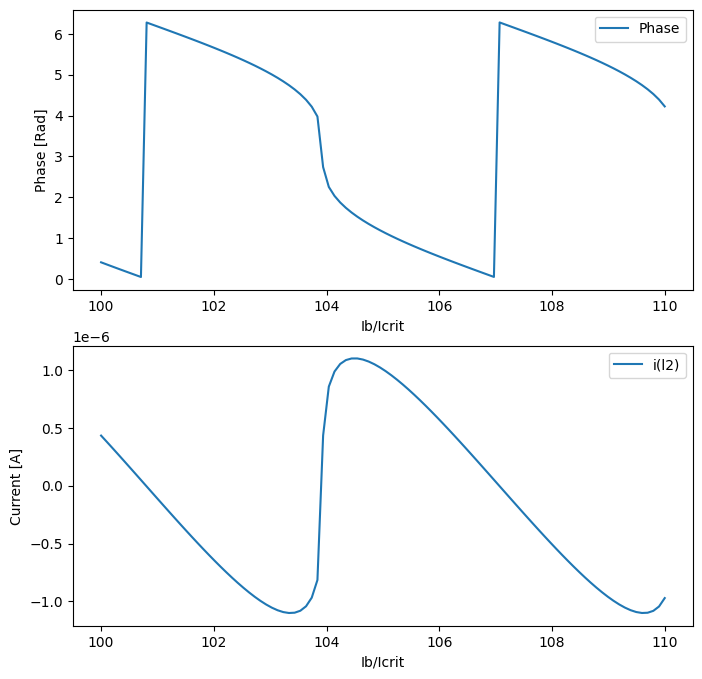

In [11]:
# Plot the data
fig, ax = plt.subplots(2, 1, figsize=(8,8))
ax[0].plot(np.linspace(100, 110, 100),  np.round(np.array(phis[:, -5]%(2*np.pi)), 12), label="Phase")
ax[0].set_xlabel("Ib/Icrit")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

ax[1].plot(np.linspace(100, 110, 100), np.round(np.array(il2s[:, -5]), 16), label="i(l2)")
#ax[1].plot(np.logspace(3, 5, 10), params['ics_mag'] * np.sin(phis[:, -5]), label="i_c sin(phi)")
ax[1].set_xlabel("Ib/Icrit")
ax[1].set_ylabel("Current [A]")
ax[1].legend()

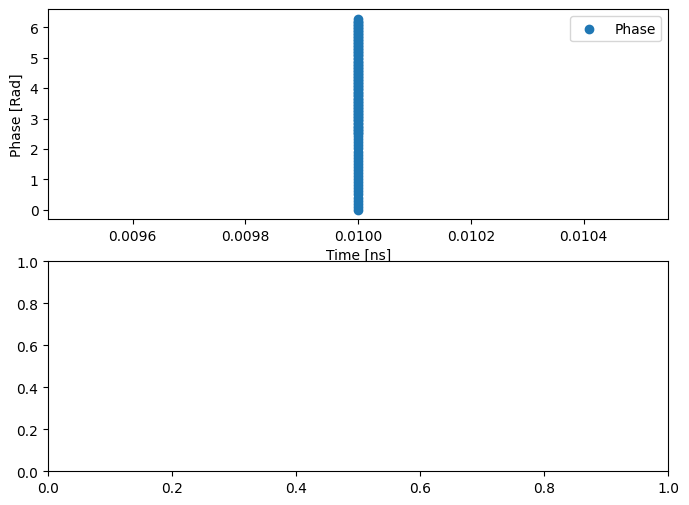

In [68]:
# Plot the data
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].scatter(np.logspace(-2, -2, 100), phis[:, -5]%(2*np.pi), label="Phase")
ax[0].set_xlabel("Time [ns]")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

# ax[1].plot(np.linspace(10e1, 10e5, 100), il2s[:, -10], label="i(l2)")
# #ax[1].plot(ts*1e9, params['ics_mag'] * np.sin(phi), label="i_c sin(phi)")
# ax[1].set_xlabel("Time [ns]")
# ax[1].set_ylabel("Current [A]")
# ax[1].legend()

### Now we look at bias currents approaching the critical current

In [24]:
%%time
# Recycle params above
params["idc_mag"] = params['ics_mag'] * np.logspace(-3, -1, 100)
params3, dat3 = engine.run_parallel(dc_bias, save_file=False, **params)

# Extract data
idcs = params3["idc_mag"]
il2s = []
phis = []
for dat in dat3:
    il2s.append(dat.to_array()[1])
    phis.append(dat.to_array()[2])
ts = dat.to_array()[0]
il2s = np.array(il2s)
phis = np.array(phis)

CPU times: user 234 ms, sys: 375 ms, total: 609 ms
Wall time: 1min 2s


In [ ]:
# Plot the data
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].plot(np.logspace(-3, -1, 100), phis[:, -10]%(2*np.pi), label="Phase")
ax[0].set_xlabel("Time [ns]")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

ax[1].plot(np.linspace(10e1, 10e5, 100), il2s[:, -10], label="i(l2)")
#ax[1].plot(ts*1e9, params['ics_mag'] * np.sin(phi), label="i_c sin(phi)")
ax[1].set_xlabel("Time [ns]")
ax[1].set_ylabel("Current [A]")
ax[1].legend()

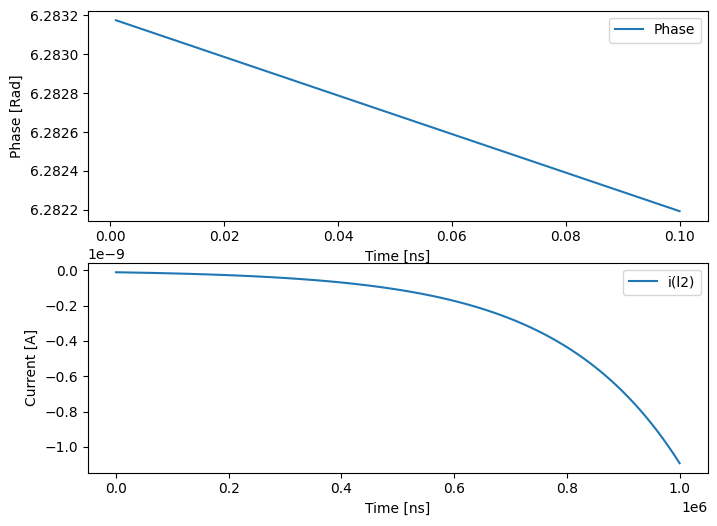

In [25]:
# Plot the data
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].plot(np.logspace(-3, -1, 100), phis[:, -10]%(2*np.pi), label="Phase")
ax[0].set_xlabel("Time [ns]")
ax[0].set_ylabel("Phase [Rad]")
ax[0].legend()

ax[1].plot(np.linspace(10e1, 10e5, 100), il2s[:, -10], label="i(l2)")
#ax[1].plot(ts*1e9, params['ics_mag'] * np.sin(phi), label="i_c sin(phi)")
ax[1].set_xlabel("Time [ns]")
ax[1].set_ylabel("Current [A]")
ax[1].legend()